In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using CairoMakie
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2,  el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [3]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

peaks (generic function with 1 method)

In [90]:
tspan = (0.0, 150000.0)

a = 1.; b = 3.; c = 1.; d = 5.;
xr = -1.6; r = 0.01; s = 5.; I = 4.; xv = 2.;
k1, k2 = -0.05, -0.05;
k = 0.0

0.0

In [91]:
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
condition = SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]

6-element SVector{6, Float64} with indices SOneTo(6):
 -1.5
  0.0
  0.0
 -2.5
  0.0
  0.0

In [92]:
prob = ODEProblem(HR, condition, tspan, p)

ODEProblem with uType SVector{6, Float64} and tType Float64. In-place: false
timespan: (0.0, 100000.0)
u0: 6-element SVector{6, Float64} with indices SOneTo(6):
 -1.5
  0.0
  0.0
 -2.5
  0.0
  0.0

In [93]:
sol = solve(prob, Vern9(), adaptive = false, dt = 0.1,  abstol = 1e-14, reltol = 1e-14, maxiters = 50000000);

In [94]:
sol

retcode: Success
Interpolation: specialized 9th order lazy interpolation
t: 1000001-element Vector{Float64}:
      0.0
      0.1
      0.2
      0.30000000000000004
      0.4
      0.5
      0.6
      0.7
      0.7999999999999999
      0.8999999999999999
      0.9999999999999999
      1.0999999999999999
      1.2
      ⋮
  99998.90000133282
  99999.00000133282
  99999.10000133283
  99999.20000133284
  99999.30000133284
  99999.40000133285
  99999.50000133285
  99999.60000133286
  99999.70000133287
  99999.80000133287
  99999.90000133288
 100000.0
u: 1000001-element Vector{SVector{6, Float64}}:
 [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
 [-0.6764604973947698, -0.4195460423206509, 0.0028952144494402573, -0.9836558857211604, -1.0785742537284164, 0.00036065600663395396]
 [-0.24318110862262227, -0.38574913172385034, 0.008649581988541833, -0.49889897728380667, -1.1314395459807527, 0.004775459421379823]
 [0.12443303402946067, -0.26066641078935204, 0.016343688415902065, -0.17569116837049886, -0.9842528

In [95]:
xsum = sol[1, :] + sol[4, :];
println("before: ", length(xsum))

xsum = xsum[floor(Int, length(xsum) / 4):end ]
println("after: ", length(xsum))

before: 1000001
after: 750002


In [96]:
Hs1 = Hs(xsum, 6)
length(xsum), Hs1

(750002, 2.3749713506344277)

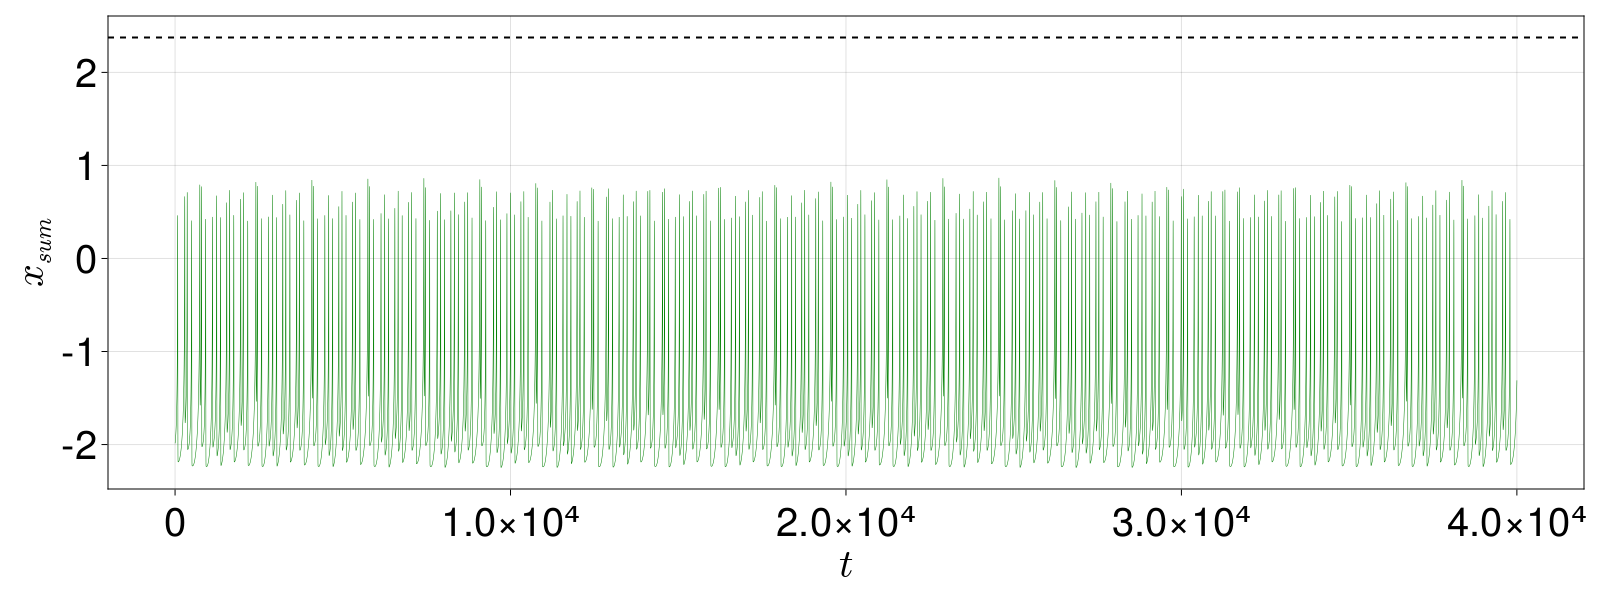

In [99]:
f = Figure(resolution = (1600, 600), fontsize = 40)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")

ts, tf = 50000, 90000

lines!(ax, xsum[ts:tf], linewidth = 0.5, color = "green")

hlines!(Hs1, color = "black", linewidth = 2.0, linestyle = :dash)

f

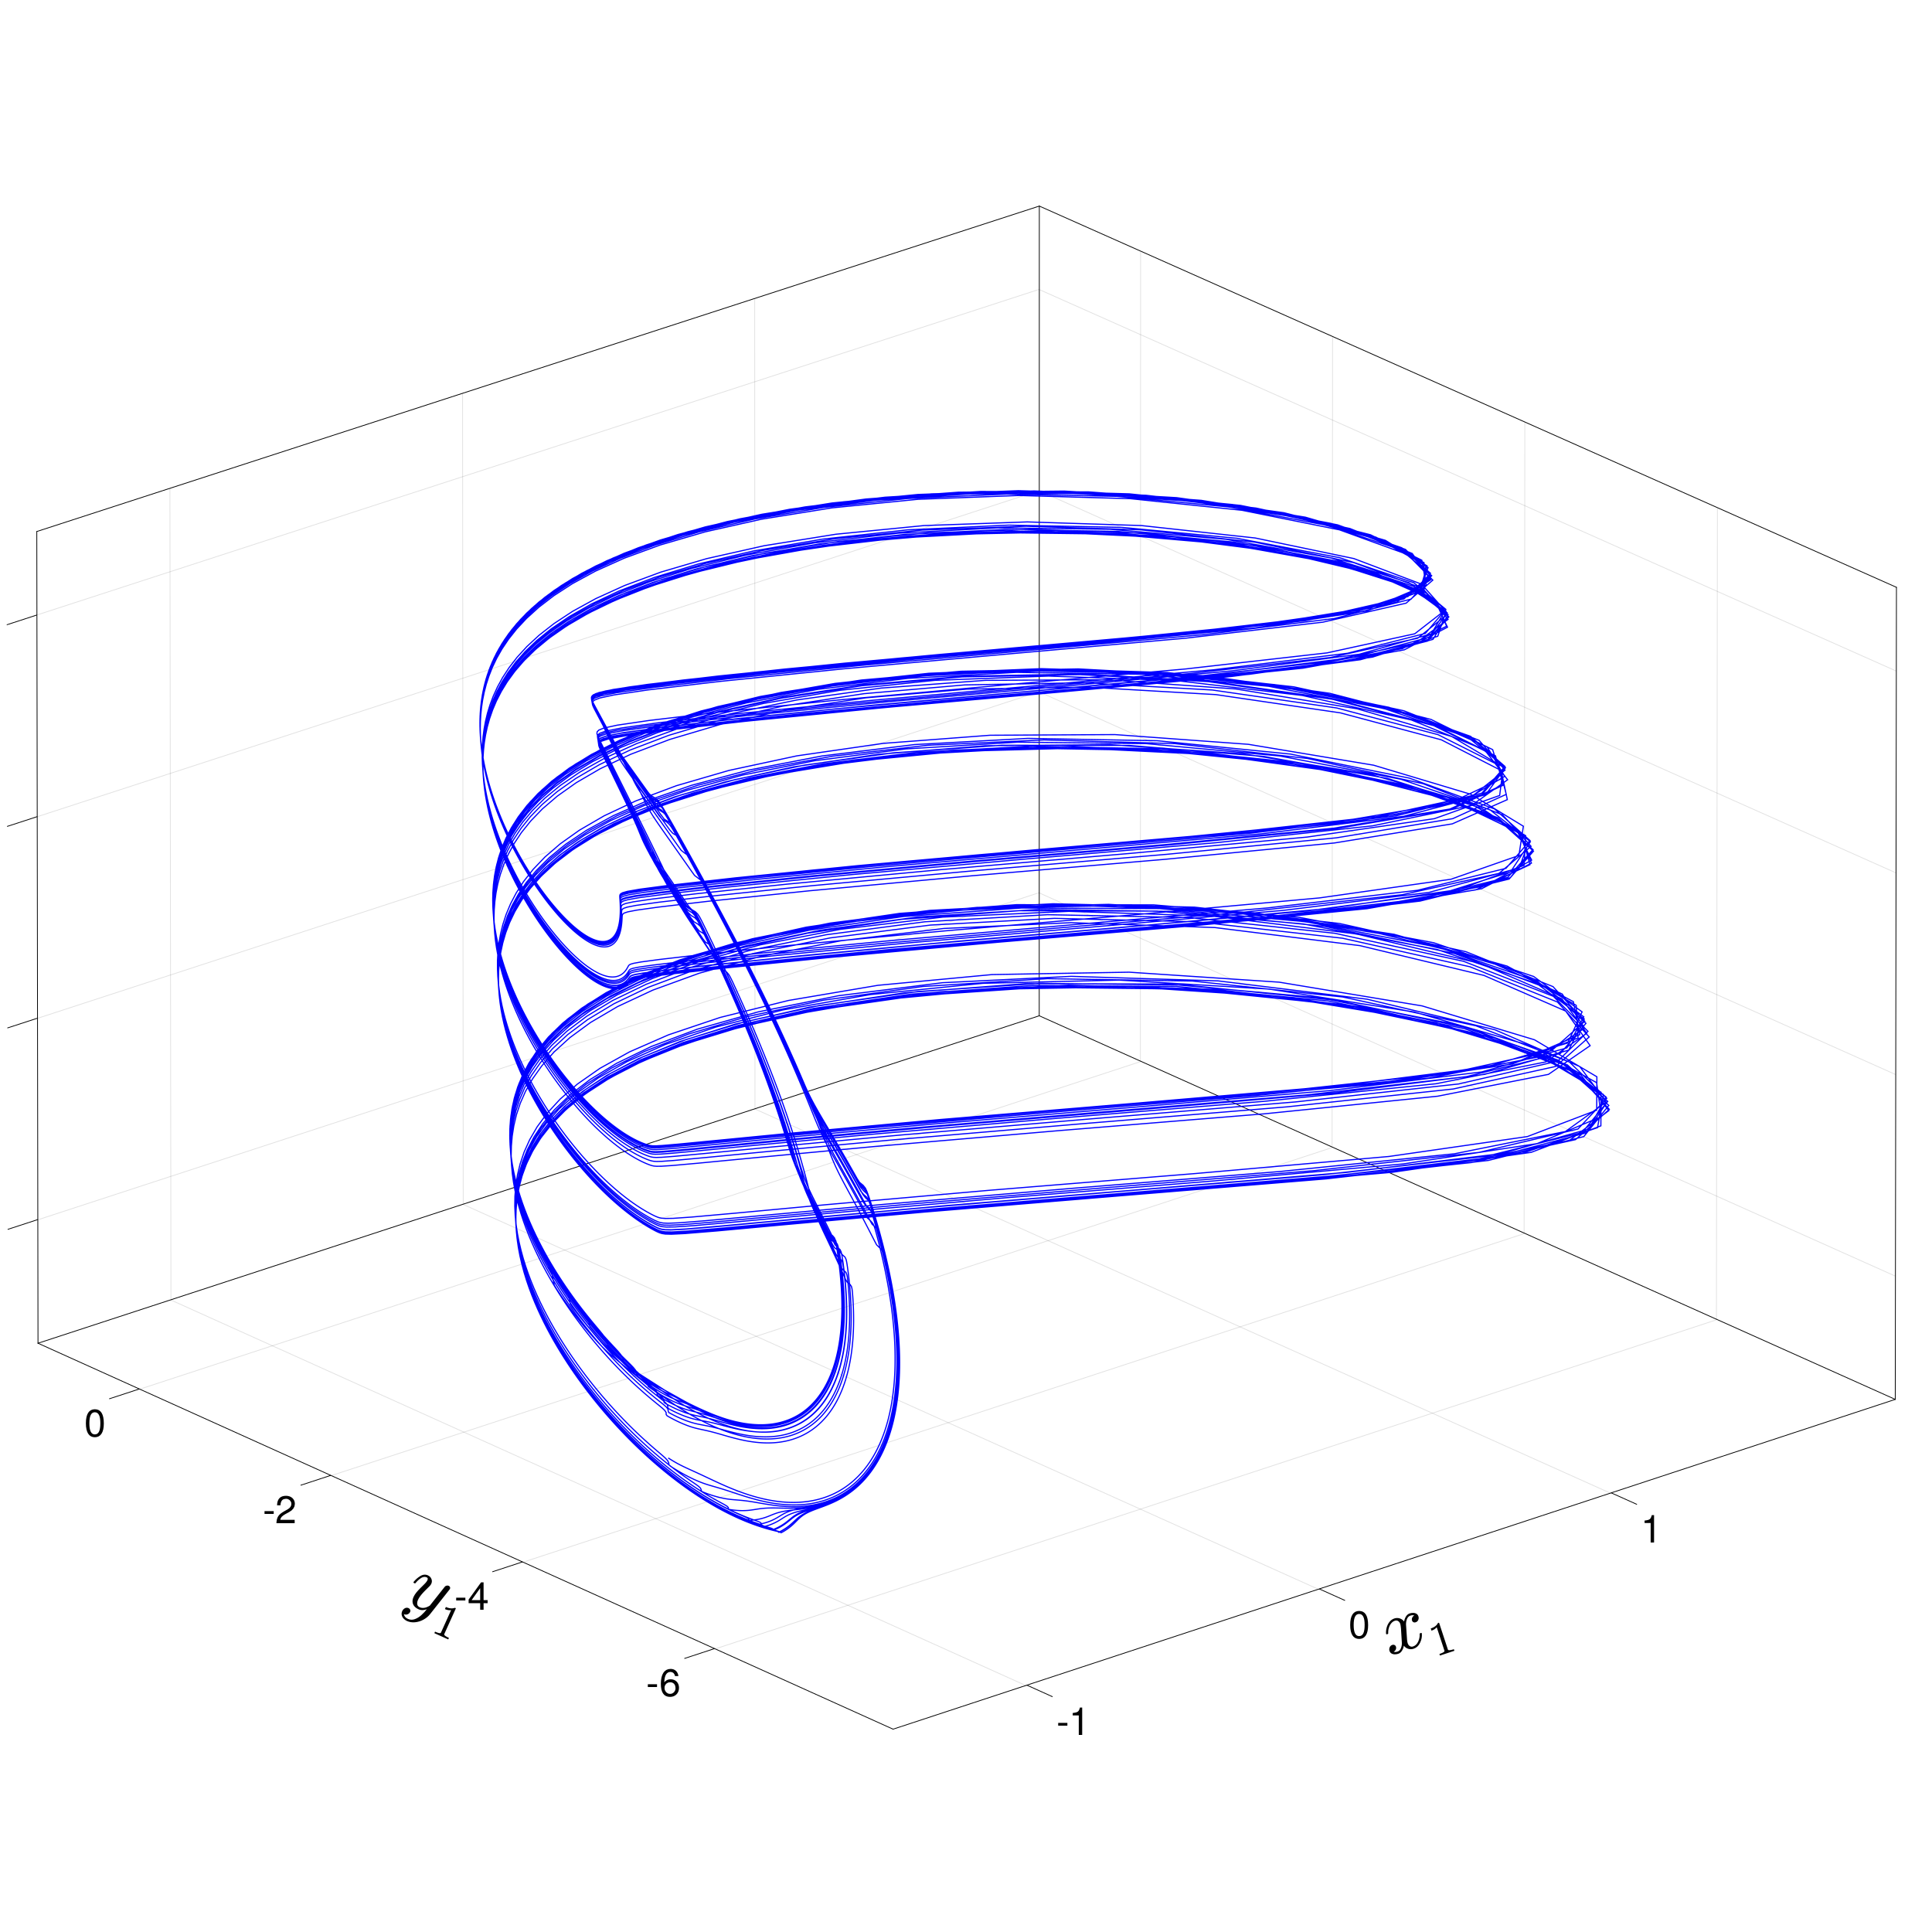

In [101]:
f = Figure(resolution = (2500, 2500), dpi = 300)

ax = Axis3(f[1, 1],
xlabel = L"x_1", ylabel = L"y_1", zlabel = L"z_1",
xlabelsize = 100, ylabelsize = 100, zlabelsize = 100,
xticklabelsize = 50, yticklabelsize = 50, zticklabelsize = 50,
zticks = range(3.6, 4.2, step = 0.2))

ts, tf = 70000, 90000

lines!(ax, sol[1, ts:tf], sol[2, ts:tf], sol[3, ts:tf], linewidth = 1.5, color = "blue" )

f

In [69]:
ds = ContinuousDynamicalSystem(HR, condition, p)

6-dimensional continuous dynamical system
 state:       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
 rule f:      HR
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.8, -0.8, 0.0]

In [70]:
t = 300000.0
Ttr = t / 2

150000.0

In [71]:
length(range(0.0, t, step = 0.01))

30000001

In [72]:
LES = lyapunovspectrum(ds, t; Ttr = Ttr, Δt = 0.1,
    diffeq = (alg = Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000 ))
    

6-element Vector{Float64}:
  1.2073578694039904
  3.513949744831031e-5
 -0.008409740619185455
 -0.17189990414088221
 -7.891951985406916
 -9.66363761086694